In [19]:
import numpy as np
from pettingzoo.sisl import multiwalker_v9
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
from tqdm import tqdm
import cv2
import random
import pickle
torch.set_float32_matmul_precision('high')
device = 'cuda:1'

https://spinningup.openai.com/en/latest/algorithms/ddpg.html

In [20]:
def split_states(states):
    s0, s1, s2 = states['walker_0'], states['walker_1'], states['walker_2']
    s0 = torch.tensor(s0, dtype=torch.float32, device=device)
    s1 = torch.tensor(s1, dtype=torch.float32, device=device)
    s2 = torch.tensor(s2, dtype=torch.float32, device=device)
    return s0, s1, s2
keys = ['walker_0', 'walker_1', 'walker_2']

def save_video_from_images(image_list, output_path, fps=30):
    if not image_list:
        raise ValueError("The image list is empty.")

    height, width, channels = image_list[0].shape
    if channels not in [1, 3]:
        raise ValueError("Images should have 1 or 3 channels (grayscale or RGB).")

    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    video_writer = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

    for img in image_list:
        if img.dtype != np.uint8:
            img = np.clip(img * 255, 0, 255).astype(np.uint8)

        if len(img.shape) == 2 or img.shape[2] == 1:
            img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
        
        video_writer.write(img)

    video_writer.release()
    print(f"Video saved at {output_path}")

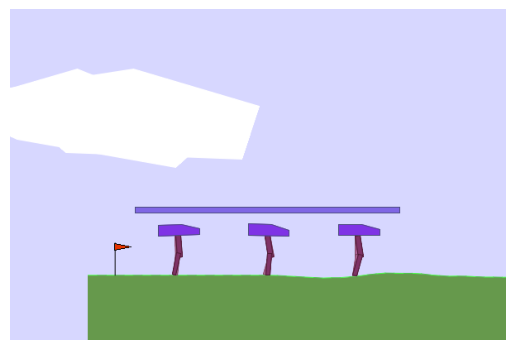

In [21]:
env = multiwalker_v9.parallel_env(render_mode='rgb_array', 
                                  forward_reward=1.0, 
                                  terminate_on_fall=True,
                                  terminate_reward=0.0,
                                  fall_reward=-10, 
                                  remove_on_fall=False,
                                  position_noise=0.0,
                                  angle_noise=0.0, 
                                  max_cycles=900, 
                                  shared_reward=False)
obs, _ = env.reset()
actions = {agent: env.action_space(agent).sample() for agent in env.agents}
obs, reward, terminations, _, _ = env.step(actions)
image = env.render()
plt.imshow(image)
plt.axis('off')
plt.show()

In [22]:
class PolicyNet(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(PolicyNet, self).__init__()

        self.input_dim = state_dim
        self.output_dim = action_dim

        self.fc = nn.Sequential(
            nn.Linear(in_features=self.input_dim, out_features=1024),
            nn.GELU(),
            nn.Linear(in_features=1024, out_features=1024),
            nn.GELU(),
            nn.Linear(in_features=1024, out_features=512),
            nn.GELU(),
            nn.Linear(in_features=512, out_features=self.output_dim),
            nn.Tanh()
        )
    def forward(self, x):
        return self.fc(x)
class QNet(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(QNet, self).__init__()

        self.input_dim = state_dim + action_dim
        
        self.fc = nn.Sequential(
            nn.Linear(in_features=self.input_dim, out_features=1024),
            nn.GELU(),
            nn.Linear(in_features=1024, out_features=1024),
            nn.GELU(),
            nn.Linear(in_features=1024, out_features=512),
            nn.GELU(),
            nn.Linear(in_features=512, out_features=1)
        )
    def forward(self, x):
        return self.fc(x)

In [23]:
Q_Nets = [torch.compile(QNet(state_dim=31, action_dim=4)).to(device) for _ in range(3)]
Policy_Nets = [torch.compile(PolicyNet(state_dim=31, action_dim=4)).to(device) for _ in range(3)]
replayBuffers = [deque(maxlen=10000) for _ in range(3)]

Q_optimisers = [optim.AdamW(q_net.parameters(), lr=1e-5) for q_net in Q_Nets]
P_optimisers = [optim.AdamW(policy_net.parameters(), lr=1e-5) for policy_net in Policy_Nets]

criterion = nn.MSELoss()

In [6]:
replayBuffers = []
walker_num = 1
for q_net, policy_net in zip(Q_Nets, Policy_Nets):
        name = "Q_net_model_" + str(walker_num)
        path = "/home/arnabdey/Placement_ML_projects/RL/Walker_Models/" + name + '.pth'
        q_net.load_state_dict(torch.load(path))
        name = "Pol_net_model_" + str(walker_num)
        path = "/home/arnabdey/Placement_ML_projects/RL/Walker_Models/" + name + '.pth'
        policy_net.load_state_dict(torch.load(path))
        name = "replay_buffer_" + str(walker_num)
        path = "/home/arnabdey/Placement_ML_projects/RL/Walker_Models/" + name + '.pkl'

        with open(path, 'rb') as f:
                loaded_dq = pickle.load(f)
        replayBuffers.append(loaded_dq)
        walker_num += 1

In [30]:
num_episodes = 500
epsilon = 1.0
epsilon_decay_factor = 0.999
gamma = 0.7
batch_size = 2048

In [ ]:
Cumulative_Rewards = []

for episode in tqdm(range(num_episodes)):
    per_episode_reward = np.array([0., 0., 0.])
    states = env.reset()[0]
    states = [torch.tensor(states[key], dtype=torch.float32) for key in keys]

    dones = [False for _ in range(3)]
    while not all(dones):
        actions = []
        for agent, state, policy_net in zip(keys, states, Policy_Nets):
            state = state.to(device)
            prob = torch.rand(1).item()
            if prob < epsilon:
                a = torch.rand(size=(4,), device=device) * 2 - 1
            else:
                with torch.no_grad():
                    a = policy_net(state)
                    # a = a +  + torch.normal(mean=0, std=epsilon, size=a.shape, device=device)
                    a = torch.clamp(a, -1, 1)
            actions.append(a.cpu().numpy())
        actions_dict = dict(zip(keys, actions))
        next_states_dict, rewards_dict, terminations_dict, info, _ = env.step(actions_dict)

        next_states = [next_states_dict[key] for key in keys]
        rewards = [rewards_dict[key] for key in keys]
        per_episode_reward += np.array(rewards)
    
        dones = [terminations_dict[key] for key in keys]

        if any(dones):
            break

        for dq, nxt_state, action, reward, state, done in zip(replayBuffers, next_states, actions, rewards, states, dones):
            nxt_state = torch.tensor(nxt_state, dtype=torch.float32, device='cpu')
            action = torch.tensor(action, dtype=torch.float32, device='cpu')
            reward = torch.tensor(reward, dtype=torch.float32, device='cpu')
            state = state.to('cpu')
            done = torch.tensor(done, dtype=torch.float32, device='cpu')
            experience = (state, action, reward, nxt_state, done)
            dq.append(experience)

        if len(replayBuffers[0]) >= batch_size:
            for dq, q_net, policy_net, q_optim, policy_optim in zip(replayBuffers, Q_Nets, Policy_Nets, Q_optimisers, P_optimisers):
                batch = random.sample(dq, batch_size)
                states, actions, rewards, nxt_states, dones = zip(*batch)
                states = torch.stack(states).to(device)
                actions = torch.stack(actions).to(device)
                nxt_states = torch.stack(nxt_states).to(device)
                rewards = torch.stack(rewards).to(device).unsqueeze(1)
                dones = torch.tensor(dones, device=device).unsqueeze(1)
                with torch.no_grad():
                    mew_theta = policy_net(nxt_states)
                    sa = torch.cat((nxt_states, mew_theta), dim=1)
                    targets = rewards + gamma * (1 - dones) * q_net(sa)
                sa = torch.cat((states, actions), dim=1)
                current_Q_vals = q_net(sa)
                loss = criterion(current_Q_vals, targets)
                q_optim.zero_grad()
                loss.backward()
                q_optim.step()

                mew_theta = policy_net(states)
                # with torch.no_grad():
                sa = torch.cat((states, mew_theta), dim=1)
                Q_vals = q_net(sa)
                policy_optim.zero_grad()
                loss_p_net = -Q_vals.mean()
                loss_p_net.backward()
                policy_optim.step()
        states = torch.tensor(np.array(next_states), dtype=torch.float32)
    Cumulative_Rewards.append(per_episode_reward)
    epsilon = max(epsilon * epsilon_decay_factor, 0.5)
Cumulative_Rewards = np.array(Cumulative_Rewards).T

  0%|          | 1/500 [00:04<37:05,  4.46s/it]

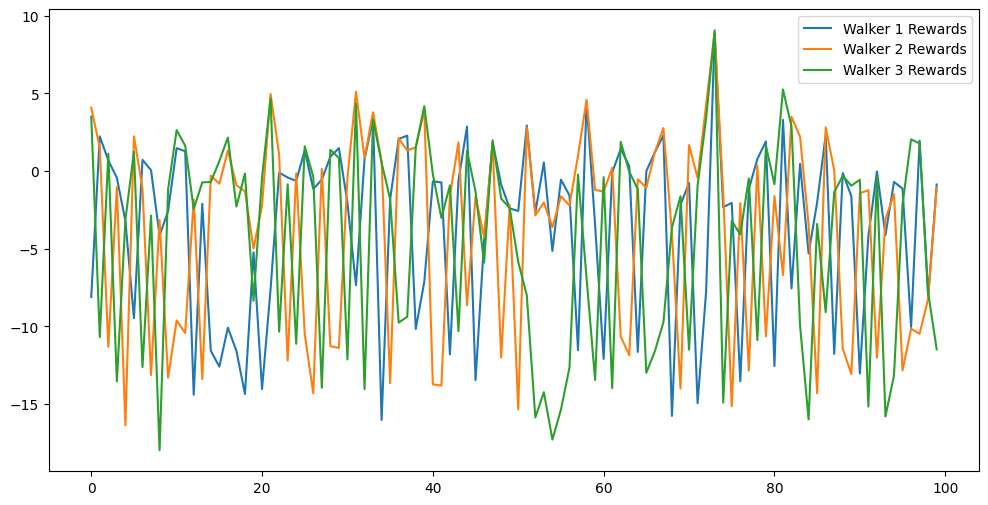

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(Cumulative_Rewards[0], label = "Walker 1 Rewards")
plt.plot(Cumulative_Rewards[1], label = "Walker 2 Rewards")
plt.plot(Cumulative_Rewards[2], label = "Walker 3 Rewards")
plt.legend()
plt.show()

# Inference

In [ ]:
dones = [False for _ in range(3)]
states = env.reset()[0]
states = [torch.tensor(states[key], dtype=torch.float32) for key in keys]
Inference_Rewards = []
Images_List = [env.render()]
steps = 0
while not all(dones):
    actions = []
    for state, policy_net in zip(states, Policy_Nets):
        with torch.no_grad():
            state = state.to(device)
            a = policy_net(state)
            actions.append(a.cpu().numpy())
    actions_dict = dict(zip(keys, actions))
    next_states_dict, rewards_dict, terminations_dict, _, _ = env.step(actions_dict)

    if len(terminations_dict) < 3:
        break

    next_states = [next_states_dict[key] for key in keys]
    rewards = [rewards_dict[key] for key in keys]
    dones = [terminations_dict[key] for key in keys]
    states = torch.tensor(np.array(next_states), dtype=torch.float32)
    steps += 1
    Images_List.append(env.render())
    Inference_Rewards.append(np.array(rewards))
print(len(Images_List))
Inference_Rewards = np.array(Inference_Rewards).T

34


In [28]:
path = "/home/arnabdey/Placement_ML_projects/RL/walking.mp4"
save_video_from_images(image_list=Images_List, output_path=path)

Video saved at /home/arnabdey/Placement_ML_projects/RL/walking.mp4


In [29]:
walker_num = 1
for q_net, policy_net, replay_buffer in zip(Q_Nets, Policy_Nets, replayBuffers):
        name = "Q_net_model_" + str(walker_num)
        path = "/home/arnabdey/Placement_ML_projects/RL/Walker_Models/" + name + '.pth'
        torch.save(q_net.state_dict(), path)
        name = "Pol_net_model_" + str(walker_num)
        path = "/home/arnabdey/Placement_ML_projects/RL/Walker_Models/" + name + '.pth'
        torch.save(policy_net.state_dict(), path)
        name = "replay_buffer_" + str(walker_num)
        path = "/home/arnabdey/Placement_ML_projects/RL/Walker_Models/" + name + '.pkl'
        with open(path, "wb") as f:
                pickle.dump(replay_buffer, f)
        walker_num += 1